This Regression model will predict what size will fit a customer based on relevant features from an online catalogue. 

Importing the libraries

In [ ]:
import numpy as np  
import pandas as pd 
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.core import shape

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

Importing the dataset

In [ ]:
with open('modcloth_final_data.json') as f:
    content = f.readlines()

data = [eval(c) for c in content]
data = pd.DataFrame(data)

Cleaning the data

In [ ]:
data.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29,7,5.0,d,38,34,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,30,36,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,NaN,32,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.00,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [ ]:
print(data.dtypes)

In [ ]:
#Re-labeling inconsistant column names 
data.columns = ['Item_Id', 'Waist', 'Size', 'Quality', 'Cup_size', 'Hips', 'Bra_size', 'Category', 'Bust', 'Height', 'User_name', 'Length', 'Fit', 'User_id', 'Shoe_size', 'Shoe_width', 'Review_summary', 'Review_test']

In [ ]:
data.info()

Total number of missing values. 

In [ ]:
def Missing_data(md):
  missing_data_sum = data.isnull().sum()
  missing_data = pd.DataFrame({'Total_missing_values': missing_data_sum,'Percentage_of_missing_values': (missing_data_sum/data.shape[0])*100})
  return missing_data

Missing_data(data)

,Total_missing_values,Percentage_of_missing_values
Item_Id,0,0.000000
Waist,79908,96.518903
Size,0,0.000000
Quality,68,0.082136
Cup_size,6255,7.555260
Hips,26726,32.281677
Bra_size,6018,7.268994
Category,0,0.000000
Bust,70936,85.681846
Height,1107,1.337118


Selecting the features relevant to the business problem

In [ ]:
data = data[['Waist','Bust','Size','Cup_size','Hips','Bra_size','Height']]
data.head()

,Waist,Bust,Size,Cup_size,Hips,Bra_size,Height
0,29,36,7,d,38,34,5ft 6in
1,31,NaN,13,b,30,36,5ft 2in
2,30,NaN,7,b,NaN,32,5ft 7in
3,NaN,NaN,21,dd/e,NaN,NaN,NaN
4,NaN,NaN,18,b,NaN,36,5ft 2in


Identifying unique values.   

In [ ]:
data['Waist'].unique()

array(['29', '31', '30', nan, '27', '26', '28', '25', '32', '34', '44',
       '33', '23', '49', '37', '42', '20', '35', '24', '36', '40', '38',
       '48', '22', '41', '21', '39', '45', '43', '46', '47', '50'],
      dtype=object)

In [ ]:
data['Bust'].unique()

array(['36', nan, '39', '34', '43', '35', '38', '33', '40', '41', '44',
       '45', '37', '30', '32', '42', '48', '46', '51', '25', '31', '26',
       '52', '22', '50', '47', '56', '58', '49', '54', '55', '53', '27',
       '28', '29', '20', '57', '23', '37-39', '24', '59'], dtype=object)

In [ ]:
data['Bust'].value_counts()

36       2055
34       1799
38        999
35        888
32        752
37        740
40        669
33        554
39        550
42        437
41        373
44        368
45        251
43        241
46        199
48        196
31        138
47        136
50        103
30         96
49         72
51         43
28         36
52         34
54         28
53         20
29         14
20         11
26          9
55          7
25          7
56          5
24          5
58          4
27          4
23          4
57          3
22          2
37-39       1
59          1
Name: Bust, dtype: int64

Irregular data to be converted in Bust column

In [ ]:
data['Bust'].unique()[-3]

'37-39'

In [ ]:
data['Bust'] =  data.Bust.astype(str).apply(lambda x : (x.split('-')[0]))

In [ ]:
data['Size'].unique()

array([ 7, 13, 21, 18, 11,  5, 30, 24, 33,  3, 27, 15,  9, 12, 26, 20,  4,
        8, 32, 38,  1,  0,  6, 31, 10, 14, 17,  2, 25])

In [ ]:
data['Cup_size'].unique()

array(['d', 'b', 'dd/e', 'c', 'ddd/f', 'dddd/g', 'i', 'a', nan, 'h', 'aa',
       'j', 'k'], dtype=object)

Used open source data to convert Cup_size measurements into numerical data¶

In [ ]:
def Convert_cup_size_to_cm(cup_size_code):
  if cup_size_code == 'aa':
    return 10, 11
  if cup_size_code == 'a':
    return 12, 13
  if cup_size_code == 'b':
    return 14, 15
  if cup_size_code == 'c':
    return 16, 17
  if cup_size_code == 'd':
    return 18, 19
  if cup_size_code == 'dd/e':
    return 20, 21
  if cup_size_code == 'ddd/f':
    return 22, 23
  if cup_size_code == 'dddd/g':
    return 24, 25
  if cup_size_code == 'h':
    return 26, 27
  if cup_size_code == 'i':
    return 28, 29
  if cup_size_code == 'j':
    return 30, 31
  if cup_size_code == 'k':
    return 32, 33 
  else:
    return str(np.nan)

In [ ]:
data['Cup_size_in_cm'] = data.Cup_size.apply(Convert_cup_size_to_cm)
data.head()

,Waist,Bust,Size,Cup_size,Hips,Bra_size,Height,Cup_size_in_cm
0,29,36,7,d,38,34,5ft 6in,"(18, 19)"
1,31,NaN,13,b,30,36,5ft 2in,"(14, 15)"
2,30,NaN,7,b,NaN,32,5ft 7in,"(14, 15)"
3,NaN,NaN,21,dd/e,NaN,NaN,NaN,"(20, 21)"
4,NaN,NaN,18,b,NaN,36,5ft 2in,"(14, 15)"


In [ ]:
# Splitting the data
def split_cup_size_data(data, index):
  if data.lower() == 'nan':
    return 0
  value = data.replace('(','').replace(')','').replace(',','')
  return value.split()[index]

In [ ]:
data['Cup_size_in_cm'] =  data.Cup_size_in_cm.astype(str).apply(lambda x : split_cup_size_data(x,0))
data.head()

,Waist,Bust,Size,Cup_size,Hips,Bra_size,Height,Cup_size_in_cm
0,29,36,7,d,38,34,5ft 6in,18
1,31,NaN,13,b,30,36,5ft 2in,14
2,30,NaN,7,b,NaN,32,5ft 7in,14
3,NaN,NaN,21,dd/e,NaN,NaN,NaN,20
4,NaN,NaN,18,b,NaN,36,5ft 2in,14


In [ ]:
#Removing Cup_size column
df = data.drop(['Cup_size'], axis = 1)
df.head()

,Waist,Bust,Size,Hips,Bra_size,Height,Cup_size_in_cm
0,29,36,7,38,34,5ft 6in,18
1,31,nan,13,30,36,5ft 2in,14
2,30,nan,7,NaN,32,5ft 7in,14
3,NaN,nan,21,NaN,NaN,NaN,20
4,NaN,nan,18,NaN,36,5ft 2in,14


In [ ]:
df['Hips'].unique()

array(['38', '30', nan, '41', '42.0', '50.0', '41.0', '49.0', '60.0',
       '36.0', '44.0', '39.0', '35.0', '38.0', '34.0', '32.0', '48.0',
       '52.0', '40.0', '46.0', '30.0', '37.0', '45.0', '55.0', '51.0',
       '33.0', '53.0', '54.0', '47.0', '59.0', '43.0', '46', '37', '40',
       '47', '44', '34', '36', '39', '57.0', '58.0', '31.0', '33', '35',
       '42', '52', '43', '31', '56.0', '51', '50', '45', '32', '60', '49',
       '48', '55', '53', '56', '54', '59', '58', '57'], dtype=object)

In [ ]:
df['Bra_size'].unique()

array(['34', '36', '32', nan, '38', '42', '40', '44', '46', '30', '48',
       '28'], dtype=object)

In [ ]:
df['Height'].unique()

array(['5ft 6in', '5ft 2in', '5ft 7in', nan, '5ft 4in', '5ft 3in',
       '5ft 5in', '5ft 10in', '5ft 8in', '5ft', '5ft 9in', '5ft 1in',
       '5ft 11in', '4ft 11in', '4ft 10in', '6ft', '3ft 4in', '4ft 9in',
       '6ft 3in', '6ft 1in', '6ft 2in', '3ft', '4ft 7in', '4ft 4in',
       '7ft 11in', '4ft 2in', '6ft 6in', '4ft 8in', '6ft 4in', '3ft 11in',
       '6ft 5in', '7ft 6in', '3ft 6in', '3ft 3in', '6ft 8in', '7ft 5in',
       '7ft 3in', '7ft 7in', '6ft 7in', '4ft 5in', '3ft 2in', '4ft 6in'],
      dtype=object)

Converting feet and inches to centimeters

In [ ]:
def Height_cm(x):
  if x.lower() != 'nan':
    x = x.replace('ft','').replace('in', '')
    h_ft = int(x.split()[0])
    if len(x.split()) > 1:
      h_inch = int(x.split()[1])
    else:
      h_inch = 0
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
    return h_cm

df['Height'] = df['Height'].astype(str).apply(Height_cm)
df.head()

,Waist,Bust,Size,Hips,Bra_size,Height,Cup_size_in_cm
0,29,36,7,38,34,167.6,18
1,31,nan,13,30,36,157.5,14
2,30,nan,7,NaN,32,170.2,14
3,NaN,nan,21,NaN,NaN,NaN,20
4,NaN,nan,18,NaN,36,157.5,14


Using k-Nearest Neighbor Imputation to predict the missing values.

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()

# finding imputation using other features (it will take couple of minutes to complete the execution)
knn_features = df[['Waist','Bust','Hips','Bra_size','Height','Cup_size_in_cm']]

df_filled = imputer.fit_transform(knn_features)


imputations = pd.DataFrame(data=df_filled, columns=['Waist','Bust','Hips','Bra_size','Height','Cup_size_in_cm'])


# remove the existing numeric columns (waist, height, hips, bra_size, bust, shoe_size ) from the main dataframe and concatenate  with knn imputed data
#mc_df = mc_data
new_data = df.drop(['Waist','Bust','Hips','Bra_size','Height','Cup_size_in_cm'], axis=1)


In [ ]:
# concatenate the imputations data with df frame
Clean_data = pd.concat([new_data, imputations], axis=1)
Clean_data.isnull().sum()

Size              0
Waist             0
Bust              0
Hips              0
Bra_size          0
Height            0
Cup_size_in_cm    0
dtype: int64

Handeling Outliers

In [ ]:
#I used a boxplot to show the outliers 
def Outliers(feature):
  plt.figure(figsize=(25, 6))
  ax = sns.boxplot(x=feature, linewidth=2.5)

# Used Inter Quartile Range calculation to find the lower & upper range
def Outliers_Range(datacolumn):
  sorted(datacolumn)
  Q1,Q3 = np.percentile(datacolumn , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

# Normal distribution function
def Distribution(feature):
  plt.figure(figsize=(25, 6))
  ax = sns.distplot(x=feature)


Size Column

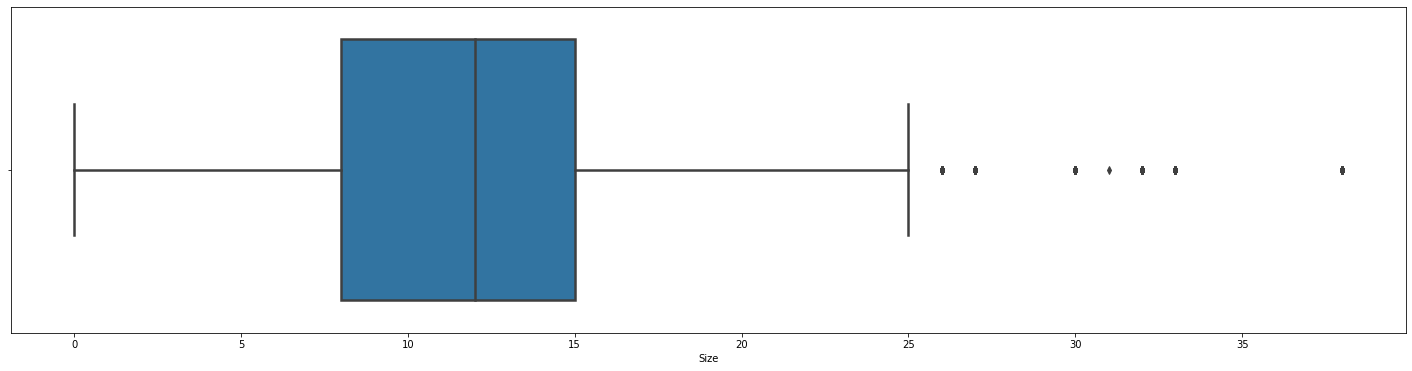

In [ ]:
Outliers(data['Size'])

In [ ]:
#The outliers would be anything less than the lower range cutoff or anything more than the upper range cutoff
ht_lower_range,ht_upper_range = Outliers_Range(Clean_data['Size'])
ht_lower_range,ht_upper_range

(-2.5, 25.5)

In [ ]:
#The the total amount of rows and columns less than the lower range and those greater than the higher range
(Clean_data[(Clean_data['Size'] < ht_lower_range) | (Clean_data['Size'] > ht_upper_range)]).shape

(10936, 7)

In [ ]:
#Removing outliers, resetting the index & checking new shape.
Clean_data = Clean_data.drop(Clean_data[(Clean_data['Size'] < ht_lower_range) | (Clean_data['Size'] > ht_upper_range)].index)
Clean_data.reset_index(drop=True, inplace=True)
Clean_data.shape

(71854, 7)

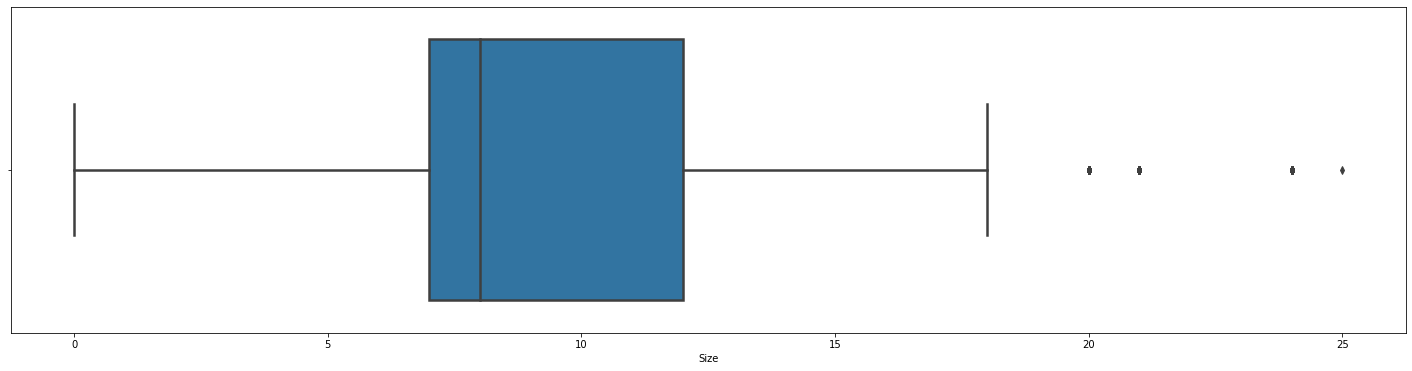

In [ ]:
# Lets look at the Size feature using box plot again to see the handling of outlier
Outliers(Clean_data['Size'])

Waist Column Boxplot

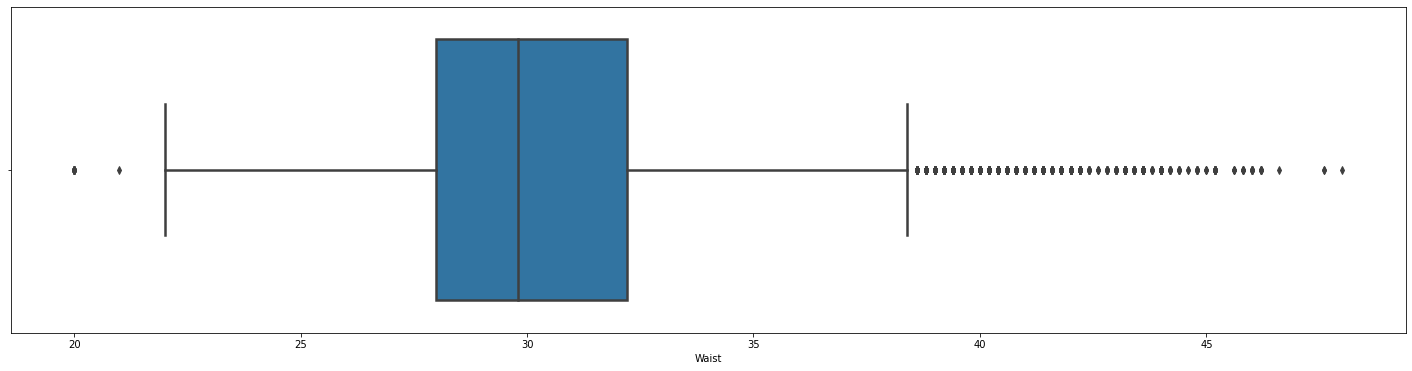

In [ ]:
Outliers(Clean_data['Waist'])

In [ ]:
#The outliers would be anything less than the lower range cutoff or anything more than the upper range cutoff
ht_lower_range,ht_upper_range = Outliers_Range(Clean_data['Waist'])
ht_lower_range,ht_upper_range

(21.699999999999996, 38.50000000000001)

In [ ]:
#The the total amount of rows and columns less than the lower range and those greater than the higher range
(Clean_data[(Clean_data['Waist'] < ht_lower_range) | (Clean_data['Waist'] > ht_upper_range)]).shape

(1819, 7)

In [ ]:
#Removing outliers, resetting the index & checking new shape.
Clean_data = Clean_data.drop(Clean_data[(Clean_data['Waist'] < ht_lower_range) | (Clean_data['Waist'] > ht_upper_range)].index)
Clean_data.reset_index(drop=True, inplace=True)
Clean_data.shape

(69879, 7)

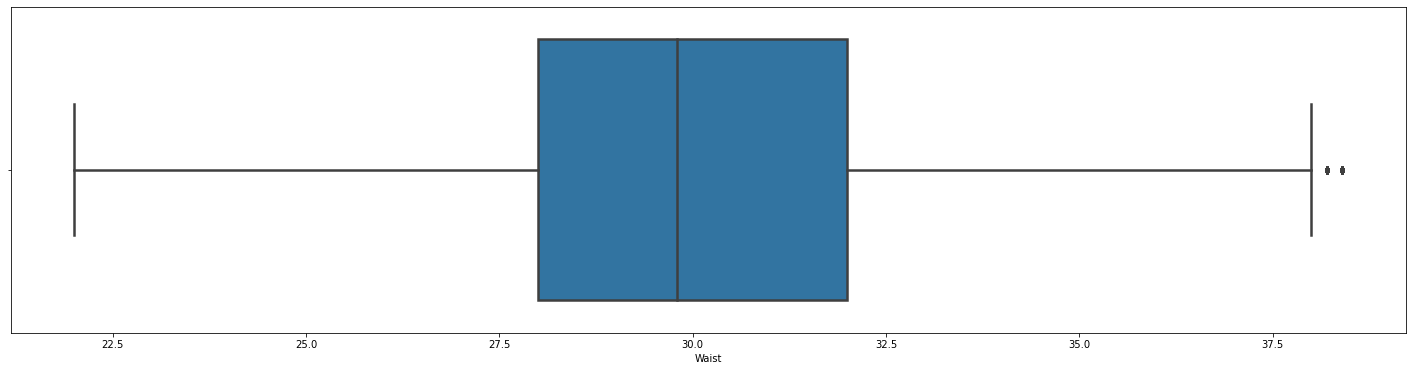

In [ ]:
# Lets look at the Waist feature using box plot again to see the handling of outlier
Outliers(Clean_data['Waist'])

Hips column

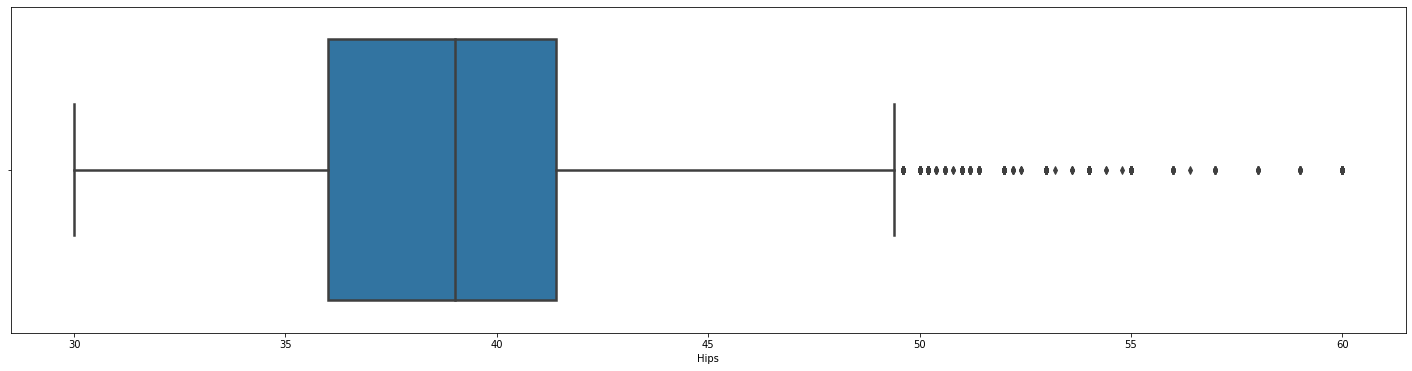

In [ ]:
Outliers(Clean_data['Hips'])

In [ ]:
#The outliers would be anything less than the lower range cutoff or anything more than the upper range cutoff
ht_lower_range,ht_upper_range = Outliers_Range(Clean_data['Hips'])
ht_lower_range,ht_upper_range

(27.900000000000002, 49.5)

In [ ]:
#The the total amount of rows and columns less than the lower range and those greater than the higher range
(Clean_data[(Clean_data['Hips'] < ht_lower_range) | (Clean_data['Hips'] > ht_upper_range)]).shape



(1111, 7)

In [ ]:
#Removing outliers, resetting the index & checking new shape. 
Clean_data = Clean_data.drop(Clean_data[(Clean_data['Hips'] < ht_lower_range) | (Clean_data['Hips'] > ht_upper_range)].index)
Clean_data.reset_index(drop=True, inplace=True)
Clean_data.shape

(68768, 7)

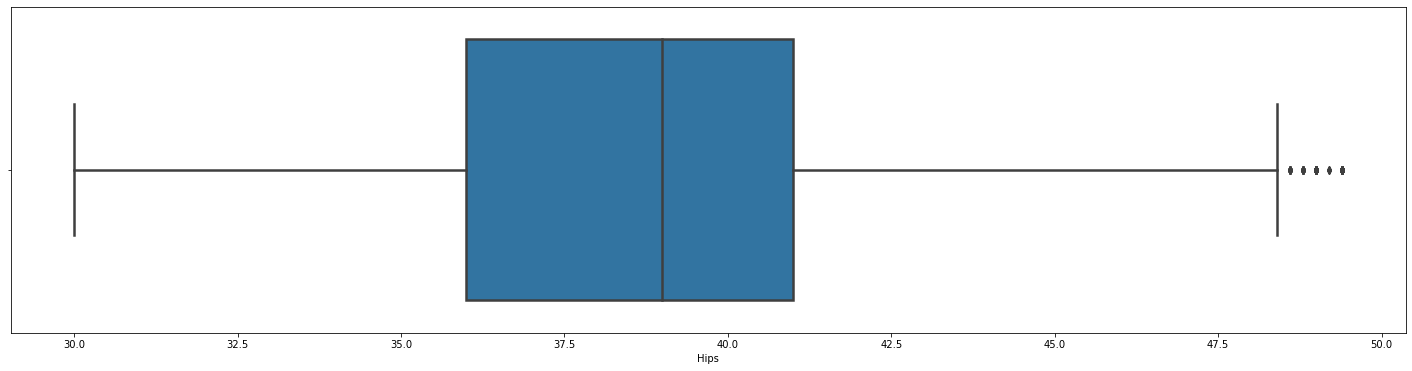

In [ ]:
#Lets look at the Hips feature using box plot again to see the handling of outlier
Outliers(Clean_data['Hips'])

Bra_size column

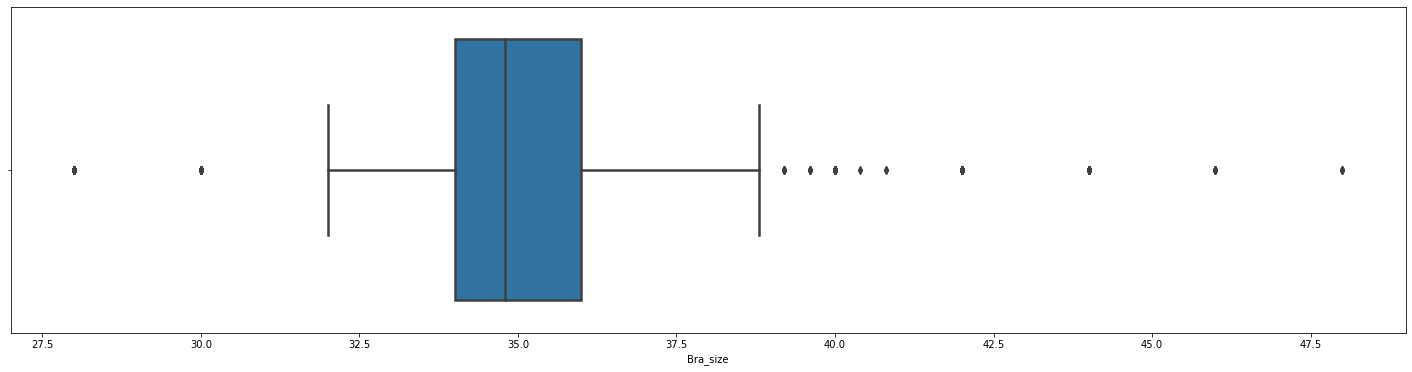

In [ ]:
Outliers(Clean_data['Bra_size'])

In [ ]:
#The outliers would be anything less than the lower range cutoff or anything more than the upper range cutoff
ht_lower_range,ht_upper_range = Outliers_Range(Clean_data['Bra_size'])
ht_lower_range,ht_upper_range

(31.0, 39.0)

In [ ]:
#The the total amount of rows and columns less than the lower range and those greater than the higher range
(Clean_data[(Clean_data['Bra_size'] < ht_lower_range) | (Clean_data['Bra_size'] > ht_upper_range)]).shape

(3712, 7)

In [ ]:
#Removing outliers, resetting the index & checking new shape. 
Clean_data = Clean_data.drop(Clean_data[(Clean_data['Bra_size'] < ht_lower_range) | (Clean_data['Bra_size'] > ht_upper_range)].index)
Clean_data.reset_index(drop=True, inplace=True)
Clean_data.shape

(65056, 7)

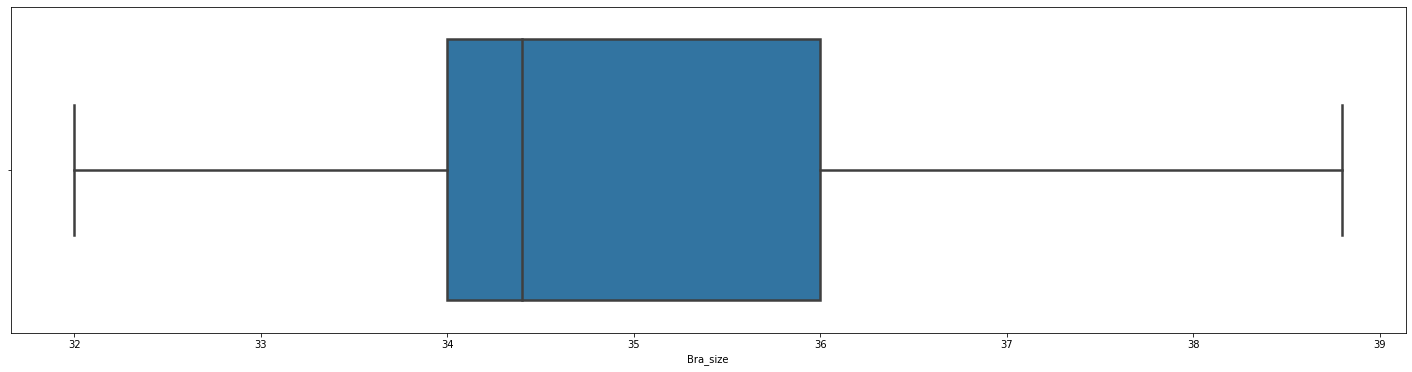

In [ ]:
# Lets look at the Bra_size feature using box plot again to see the handling of outlier
Outliers(Clean_data['Bra_size'])

Height column

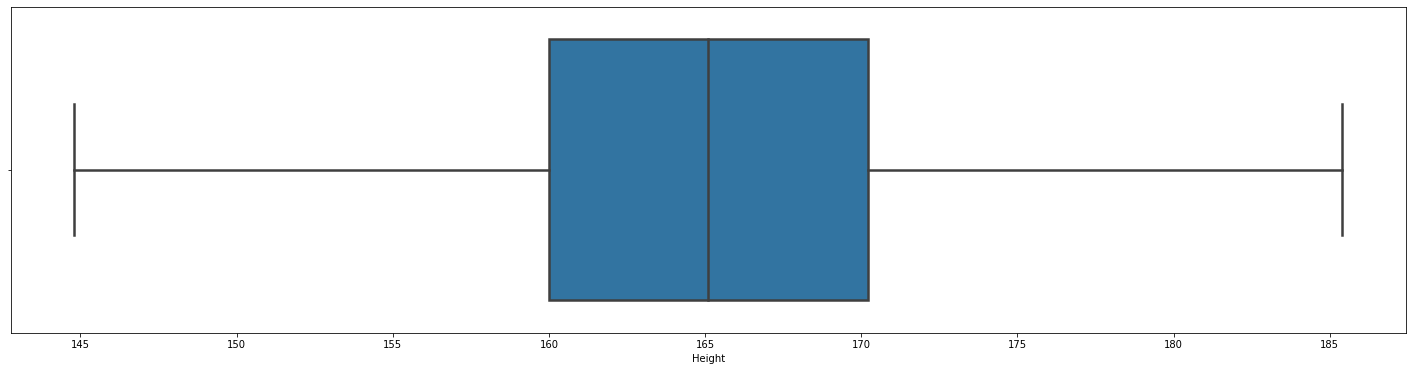

In [ ]:
Outliers(Clean_data['Height'])

In [ ]:
#The outliers would be anything less than the lower range cutoff or anything more than the upper range cutoff
ht_lower_range,ht_upper_range = Outliers_Range(Clean_data['Height'])
ht_lower_range,ht_upper_range

(144.70000000000002, 185.49999999999997)

In [ ]:
#The the total amount of rows and columns less than the lower range and those greater than the higher range
(Clean_data[(Clean_data['Height'] < ht_lower_range) | (Clean_data['Height'] > ht_upper_range)]).shape

(0, 7)

In [ ]:
#Removing outliers, resetting the index & checking new shape.
Clean_data = Clean_data.drop(Clean_data[(Clean_data['Height'] < ht_lower_range) | (Clean_data['Height'] > ht_upper_range)].index)
Clean_data.reset_index(drop=True, inplace=True)
Clean_data.shape

(65056, 7)

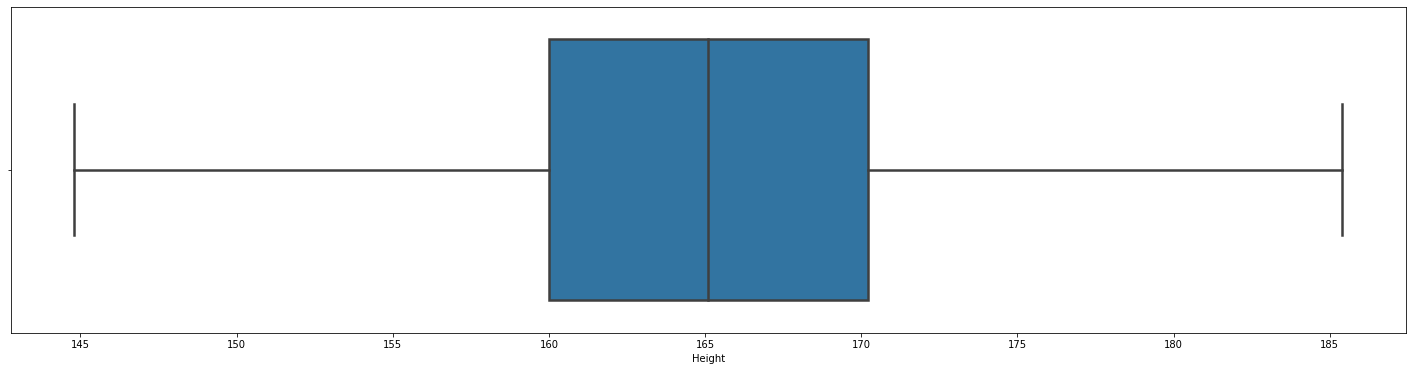

In [ ]:
#Lets look at the Height feature using box plot again to see the handling of outlier
Outliers(Clean_data['Height'])

Cup_size_in_cm column

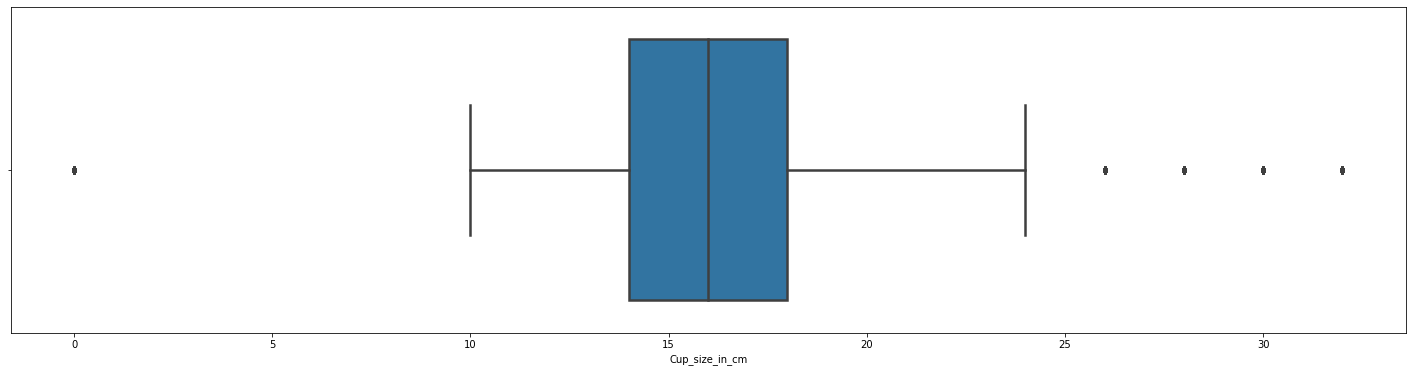

In [ ]:
Outliers(Clean_data['Cup_size_in_cm'])

In [ ]:
#The outliers would be anything less than the lower range cutoff or anything more than the upper range cutoff
ht_lower_range,ht_upper_range = Outliers_Range(Clean_data['Cup_size_in_cm'])
ht_lower_range,ht_upper_range

(8.0, 24.0)

In [ ]:
#The the total amount of rows and columns less than the lower range and those greater than the higher range
(Clean_data[(Clean_data['Cup_size_in_cm'] < ht_lower_range) | (Clean_data['Cup_size_in_cm'] > ht_upper_range)]).shape

(5807, 7)

In [ ]:
#Removing outliers, resetting the index & checking new shape.
Clean_data = Clean_data.drop(Clean_data[(Clean_data['Cup_size_in_cm'] < ht_lower_range) | (Clean_data['Cup_size_in_cm'] > ht_upper_range)].index)
Clean_data.reset_index(drop=True, inplace=True)
Clean_data.shape

(59249, 7)

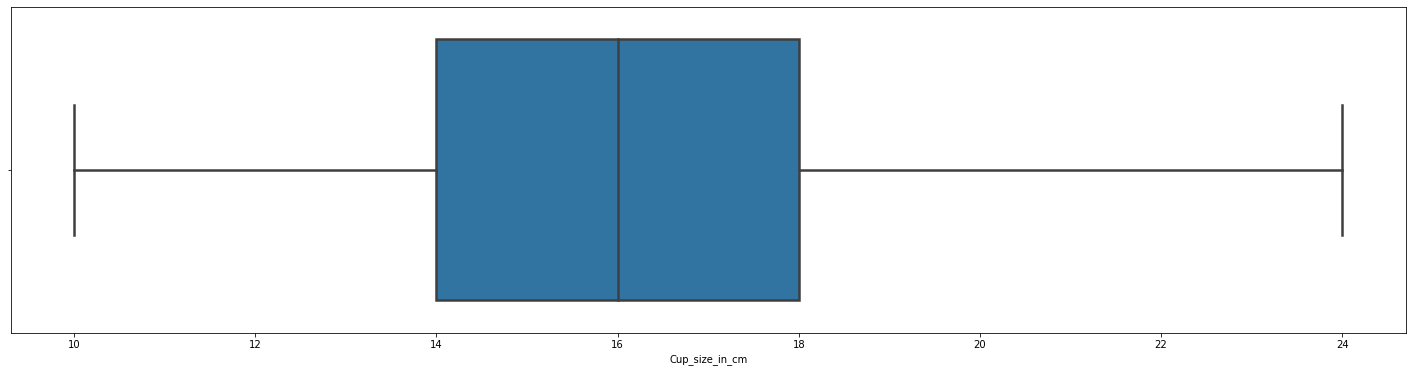

In [ ]:
# Lets look at the Cup_size_in_cm feature using box plot again to see the handling of outlier
Outliers(Clean_data['Cup_size_in_cm'])

Feature Correlation

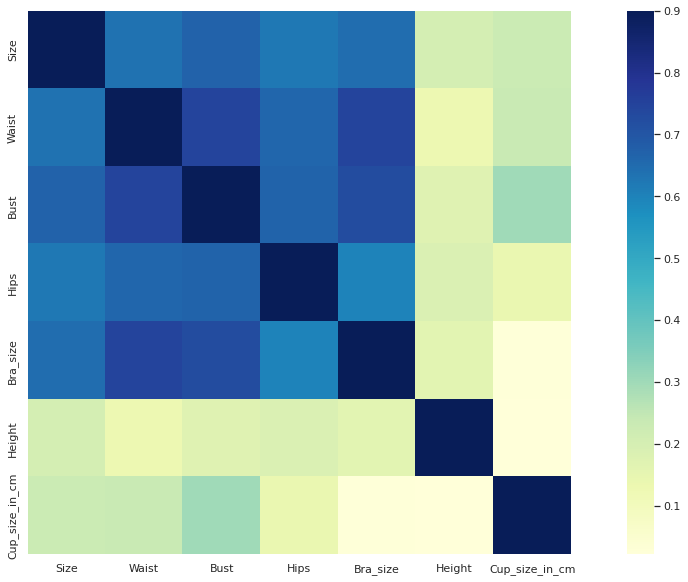

In [ ]:
corrmat = Clean_data.corr()
plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.9, cmap="YlGnBu", square=True)

Correlation Matrix with Heatmap can be used to identify the features most related to the size column and determine the relationship/association between the 'size' column (which is the target variable) and the other variables. The darker the colour, the stronger the relationship with 'size'. Which are Waist, Bust, Hips and Bra_size

Splitting the dataset into features and labels, X, y data

In [ ]:
X = Clean_data.drop(['Size','Height','Cup_size_in_cm'],axis=1).values
y = Clean_data.Size.values

Splitting the dataset into the Training set and Test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Applying PCA

In [ ]:
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

Training the XGB Regression model on the Training set

In [ ]:
Regressor = model = XGBRegressor()
Regressor.fit(X_train, y_train)

[07:16:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

Applying k-Fold Cross Validation

In [ ]:
#define model evaluation method
cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=1)
#evaluate model
scores = cross_val_score(Regressor, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.578 (0.012)


This score can be improved, meaning the model has skill and close to the best score of 1.9